# Feature selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,cohen_kappa_score, matthews_corrcoef
from scipy.stats import mode

Upload scaled data file obtained during the pre-processing step.  
Separate also variables dataframe (X) and response variable (y). Also is established a group according to "id" variable, representing each subject.

In [2]:
#Upload CSV file
scaled_data = pd.read_csv("Data/scaled_data.csv")

X = scaled_data.iloc[:, 1:754]  # Features
y = scaled_data.iloc[:, 754]    # Class
grup = scaled_data["id"]        # Establish as indivisible group: subject id for CV

To select the features, multiple methods will be applied. Each method will incorporate a cross-validation step to evaluate the performance of the selected features. The number of features selected will be based on the best metrics achieved during the cross-validation process.

For the cross-validation, a Random Forest classifier will be used and data will be split using Stratified Group K-Fold, which ensures that observations from the same subject are kept together within each fold. Additionally, the data splits will be balanced to account for class distribution.

Considering that each subject is represented by three different observations, a voting process will be applied to classify the subject into either the Parkinson's or healthy group. This process will aggregate the predictions from all three observations to determine the final classification for each subject. The majority vote from the individual observations will dictate the subject's group classification.

To achieve this, first will be defined a function for the cross-validation process. The metrics to be evaluated include accuracy, F1-score, kappa, and Matthews correlation coefficient (MCC).

In [3]:
def cv_rf(sel_features, y, grup, num_features):
    """
    Cross-validation with SGKF and Random forest
    """
    
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=123)
    rf = RandomForestClassifier(random_state=123, class_weight="balanced")
    
    pred_rf = []
    labels = []
    
    # Cross-validation
    for train_idx, test_idx in sgkf.split(sel_features, y, groups=grup):
        X_train, X_test = sel_features.iloc[train_idx], sel_features.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        rf.fit(X_train, y_train)

        # Prediction
        rf_predictions = rf.predict(X_test)
        
        # Add prediction and labels
        pred_rf.extend(rf_predictions)
        labels.extend(y_test)
        
    # Predictons voting for each patient 
    final_pred_rf = []
    for i in range(0, len(labels), 3):  # 3 entrances for patient
        patient_preds = pred_rf[i:i+3]
        
        final_rf = mode(patient_preds).mode.item()
        final_pred_rf.append(final_rf)
     
    # Metrics calculation
    accuracy = accuracy_score(labels[::3], final_pred_rf)
    f1 = f1_score(labels[::3], final_pred_rf, average='weighted')
    kappa = cohen_kappa_score(labels[::3], final_pred_rf)
    mcc = matthews_corrcoef(labels[::3], final_pred_rf)
    
    
    # Results summary
    result = {
        'num_features': num_features,
        'accuracy': accuracy,
        'F1': f1,
        'Kappa': kappa,
        'MCC': mcc,
    }
    return result

In [4]:
def metric_plot(df):
    """ 
    Plot metrics obtained with cv_rf
    """
       
    # Plot grid
    fig, axs = plt.subplots(2,2, figsize = (10,8))
    fig.suptitle("Performance Metrics")
    
    #Accuracy plot
    axs[0,0].plot(df['num_features'], df['accuracy'], marker = 'o')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_xlabel('Num. Features')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].grid(True)
    
    #F1 plot
    axs[0,1].plot(df['num_features'], df['F1'], marker = 'o')
    axs[0, 1].set_title('F1-score')
    axs[0, 1].set_xlabel('Num. Features')
    axs[0, 1].set_ylabel('F1-score')
    axs[0, 1].grid(True) 
    
    # Kappa
    axs[1,0].plot(df['num_features'], df['Kappa'], marker="o")
    axs[1,0].set_title('Kappa')
    axs[1,0].set_xlabel('Num. Features')
    axs[1,0].set_ylabel('Kappa')
    axs[1,0].grid(True) 
    
     # MCC
    axs[1,1].plot(df['num_features'], df['MCC'], marker='o')
    axs[1,1].set_title('MCC')
    axs[1,1].set_xlabel('Num. Features')
    axs[1,1].set_ylabel('MCC')
    axs[1,1].grid(True)    
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()   

## Minimum Redundancy Maximum Relevance (mRMR) 

Feature selection is performed using the Minimum Redundancy Maximum Relevance (mRMR) method. The number of features, ranging from 1 to 100, will be tested through cross-validation. The optimal number of features to be selected will be determined based on the best performance metrics obtained during this process.

In [5]:
import mrmr
from mrmr import mrmr_classif

In [6]:
np.random.seed(123)

results_mrmr = []

for n_features in range(1, 101,2): # k as number of features selected
    
    # mRMR
    selected_features = mrmr_classif(X=X, y=y, K=n_features)

    # Cross-validation
    X_subset = X[selected_features]
    result = cv_rf(X_subset, y, grup, num_features=n_features)
    results_mrmr.append(result)
    
results_mrmr_df = pd.DataFrame(results_mrmr)

100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.65it/s]


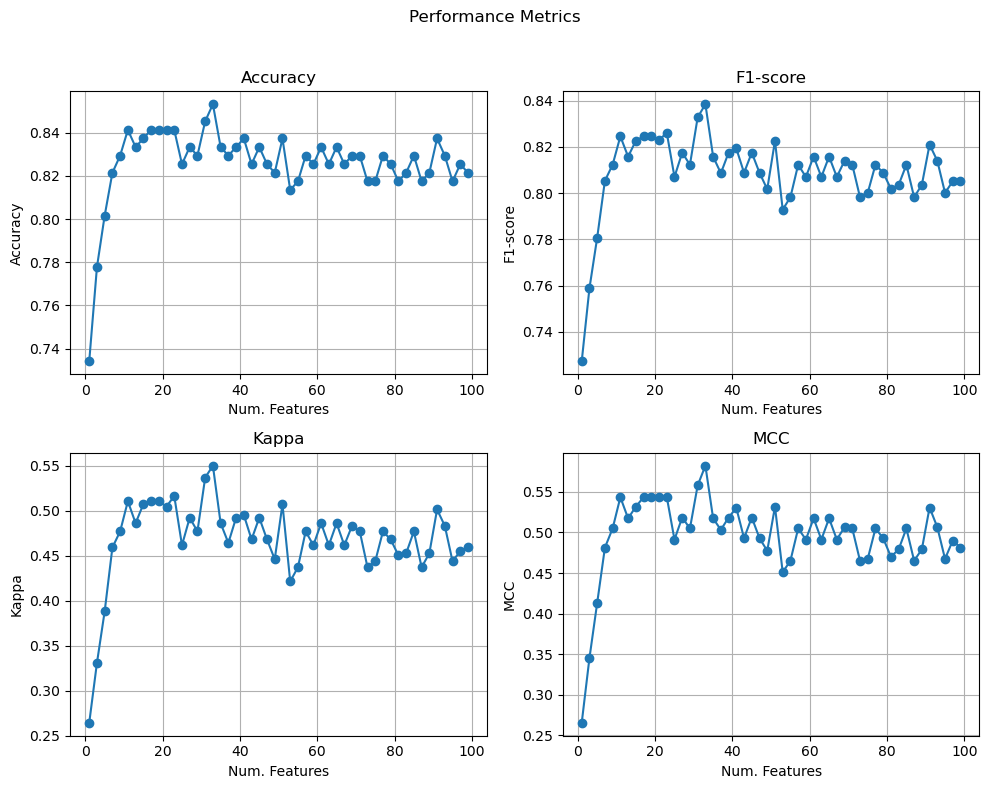

In [7]:
# Plot performance according to number of features
metric_plot(results_mrmr_df)

The best performance metrics are achieved when 33 features are selected.

Next, perform feature selection using mRMR with the 33 selected features, and save the names of the chosen variables for further analysis.

In [8]:
np.random.seed(123)

# mRMR with 33 features
for n_features in range(33, 34):
    mrmr_features = mrmr_classif(X=X, y=y, K=n_features)

    # Cross-validation
    X_subset = X[mrmr_features]
    result_mrmr = cv_rf(X_subset, y, grup, num_features=n_features)
print(pd.DataFrame([result_mrmr]))

100%|███████████████████████████████████████████| 33/33 [00:01<00:00, 22.94it/s]


   num_features  accuracy        F1     Kappa       MCC
0            33  0.853175  0.838468  0.549913  0.582212


## Recursive Feature Elimination

Feature selection is carried out using the Recursive Feature Elimination (RFE) method. The number of features, ranging from 1 to 100, will be evaluated. In this case, a Support Vector Machine model is used as the estimator to eliminate features at each step. For the cross-validation, a Random Forest classifier will be applied, as done in previous steps. The optimal number of features to select will be determined based on the best performance metrics achieved during this process.

In [9]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

In [10]:
np.random.seed(123)
results_rfe = []

for n_features in range(1, 101,2):
    
    # Determine estimator
    estimator = SVC(kernel='linear', class_weight='balanced', random_state=123)
    
    # RFE
    rfe = RFE(estimator, n_features_to_select=n_features)
    rfe.fit(X,y)
    selected_features = X.columns[rfe.support_]
    
    # Cross-validation
    X_subset = X[selected_features]
    result = cv_rf(X_subset, y, grup, num_features=n_features)
    results_rfe.append(result)
    
results_rfe_df = pd.DataFrame(results_rfe)

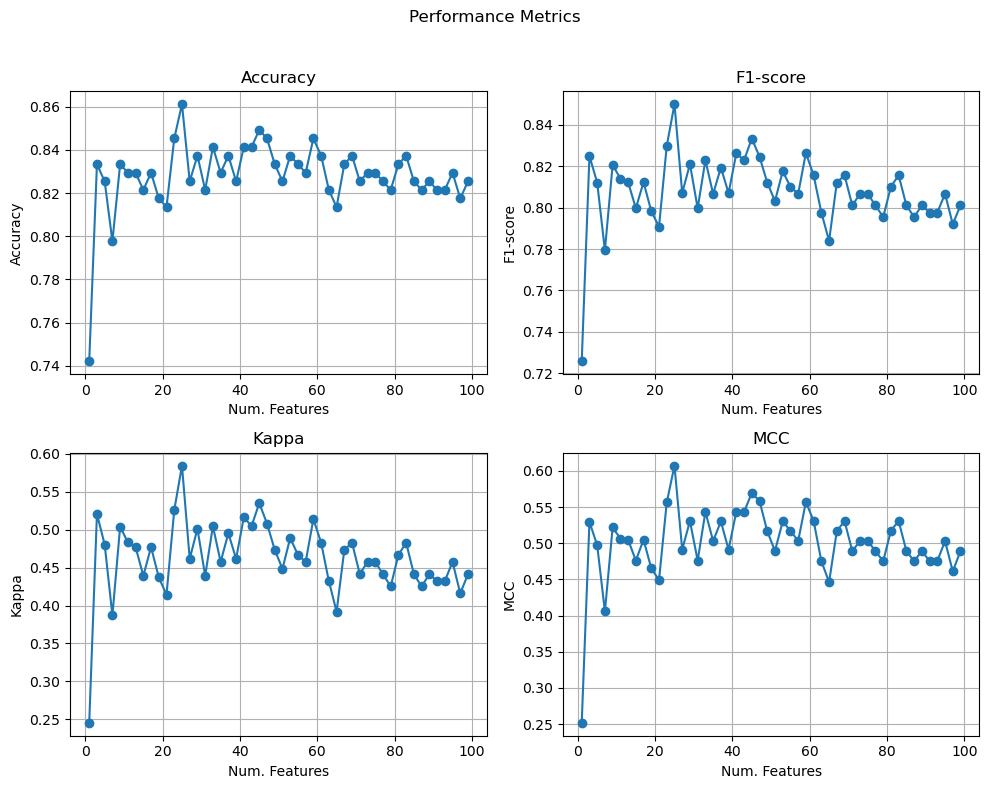

In [11]:
metric_plot(results_rfe_df) 

The best performance metrics are achieved when 25 features are selected.

Next, perform feature selection using RFE with the 25 selected features, and save the names of the chosen variables for further analysis.

In [12]:
# RFE with 25 features
np.random.seed(123)

for n_features in range(25,26):
    
    # Determine estimator
    estimator = SVC(kernel='linear', class_weight='balanced', random_state=123)
    
    # RFE
    rfe = RFE(estimator, n_features_to_select=n_features)
    rfe.fit(X,y)
    rfe_features = X.columns[rfe.support_]
    
    # Cross-validation
    X_subset = X[rfe_features]
    result_rfe = cv_rf(X_subset, y, grup, num_features=n_features)

print(pd.DataFrame([result_rfe]))

   num_features  accuracy        F1     Kappa       MCC
0            25  0.861111  0.849903  0.584198  0.607308


# Genetic Algorithm

Feature selection is performed using the Genetic Algorithm (GA) to optimize subsets of features, selecting between 1 and 100 features, while maximizing the MCC through cross-validation at each generation.

The process begins by generating an initial population of 80 individuals, each representing a subset of features with sizes varying between 1 and 100. The algorithm runs for 40 generations, evolving the population over time. For each generation, 15 pairs of parents are selected to produce offspring using a uniform crossover strategy and a mutation rate of 10%. Parent selection is based on Stochastic Uniform Sampling, favoring individuals with higher fitness scores. The fitness function evaluates the MCC for each individual in the population through cross-validation. The algorithm iteratively refines the feature subsets, aiming to maximize the MCC with each generation.

In [13]:
import pygad
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score

In [14]:
def custom_score(y_true, y_pred):
    '''
    Calculate MCC as score
    '''
    return matthews_corrcoef(y_true, y_pred)



def fitness_func(ga_instance, solution, solution_idx):
    '''
    Maximize MCC in cross-validation
    '''
    # Selected features
    selected_features = np.where(solution == 1)[0]  
    if len(selected_features) < 1 or len(selected_features) > 101:
        return 0  
    
    # Subset de les característiques seleccionades
    X_selected = X.iloc[:, selected_features]
    
    # Cross-Validation
    rf = RandomForestClassifier(class_weight="balanced", random_state=123, n_jobs=-1)
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=123)

    scores = cross_val_score(rf, X_selected, y, 
                             cv=sgkf.split(X_selected, y, groups=grup),
                             scoring=make_scorer(custom_score))
    
    # Return MCC score
    return np.mean(scores)



def custom_initialization(pop_size, num_genes, seed=123):
    '''
    Initializes population. For each individual select from 1 to 100 random variables
    '''
    np.random.seed(seed)
    population = np.zeros((pop_size, num_genes), dtype=int)
    for i in range(pop_size):
        num_selected = np.random.randint(1, 100)         
        selected_genes = np.random.choice(num_genes, num_selected, replace=False)  
        population[i, selected_genes] = 1
    return population



# Genetic Algorithm settings
ga_instance = pygad.GA(
    num_generations=30,           # 30 generations                          
    num_parents_mating=15,        # Num parents to conform next generation   
    fitness_func=fitness_func,    # Fitness score
    sol_per_pop=80,               # Number of solutions per population       
    num_genes=X.shape[1],         # Number features
    gene_space=[0, 1],            # Gene included (1) or excluded (0)
    parent_selection_type="sss",  # Stochastic Sampling, more probability if good fitness
    crossover_type="uniform",     # Crossover uniforme
    mutation_type="random",       # Random mutation
    mutation_percent_genes=0.1,   # % mutated genes (10%) 
    initial_population=custom_initialization(80, X.shape[1]),  # Inicialització personalitzada   
    random_seed=123
)

In [15]:
np.random.seed(123)

# Run Genetic Algorithm
ga_instance.run()

# Final results
solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [16]:
selected_features = np.where(solution == 1)[0]
print("Number of selected features:",len(selected_features))
print("Best MCC:", solution_fitness)

Number of selected features: 55
Best MCC: 0.637197513334318


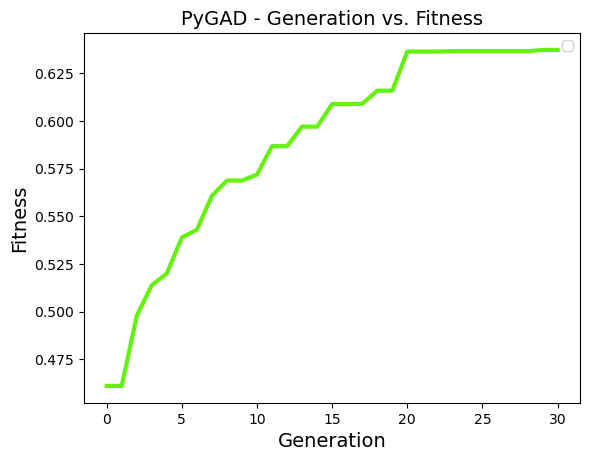

Figure(640x480)


In [17]:
# Plot: evolution of fitness across generations
print(ga_instance.plot_fitness())

In [18]:
ga_features= scaled_data.columns[selected_features]

## Saving Selected Variables

The subsets of variables identified through the different feature selection methods are saved into a new file for further analysis:

In [27]:
# Create feature_selection.py with selected varaibles
with open("Data/feature_selection.py", "w") as f:
    f.write(f'mrmr_features= {mrmr_features}\n')
    f.write(f'rfe_features={rfe_features}\n')
    f.write(f'ga_features={ga_features}\n')